## **Question 1: Check that the GPU is properly selected**


In [ ]:
!nvidia-smi

## **Question 2: Installing PyTorch Lightning**

In [ ]:
!pip install pytorch_lightning torchinfo

## **Question 3: Downloading the training dataset: railway-construction-50** ##

In [ ]:
!rm -r sample_data/
!mkdir dataset/
!wget https://nextcloud.ig.umons.ac.be/s/TaNbLXW8BrES5Te/download/railway-construction-100.zip -O railway-construction-100.zip
!unzip -q railway-construction-100.zip -d dataset/
!rm railway-construction-100.zip

## **Question 4: Importing the libraries** ##

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import cv2
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
from torchmetrics import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.classification import MulticlassConfusionMatrix
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import pandas as pd

# **Question 5: Define the training parameters "Hyperparameters"**

In [63]:
# Hyperparameters
dataset_path = "dataset/railway-construction-100/"  #@param ["dataset/railway-construction-50/","dataset/railway-construction-100/","dataset/railway-construction-big/"] {type:"string"}
batch_size = 32 #@param [8,16,32,64,128,256] {type:"raw"}
train_split = 0.8 #@param {type:"slider", min:0.5, max:0.9, step:0.05}
val_split = 0.1 #@param {type:"slider", min:0.1, max:0.5, step:0.05}
epochs = 20 #@param [1,5, 10,20,50,100,200] {type:"raw"}
learning_rate = 0.01  #@param [0.1, 0.01,0.02,0.05,0.001,0.002,0.005] {type:"raw"}
img_size = 224
num_classes = 4
LOG_DIR = "logs/"
model_name="efficientnet_v2_s" # @param ["resnet50", "MobileNet_v2", "efficientnet_v2_s","vit_b_16"]


## **Question 6: Carefully analyze the "Model" class before completing it**

In [64]:
def get_model(model_name, num_classes):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name =="efficientnet_v2_s":
        model = models.efficientnet_v2_s(weights="DEFAULT")
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name =="MobileNet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    return model

In [65]:
class Model(pl.LightningModule):
    def __init__(self, model_name, num_classes=4, learning_rate=3e-4):
        super().__init__()
        self.model = get_model(model_name, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.save_hyperparameters()
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)  # Extraire les classes prédiction
        acc = self.train_accuracy(predicted, labels)

        self.log_dict({'train_loss':loss,"train_acc":acc}, on_step=True,prog_bar=True,logger=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        val_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        val_acc = self.val_accuracy(predicted, labels)
        self.log_dict({'val_loss':val_loss,"val_acc":val_acc},prog_bar=True, on_step=False, on_epoch=True)
        return {'val_loss': val_loss, 'val_acc': val_acc}

    def on_validation_epoch_end(self):
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        test_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        test_acc = self.test_accuracy(predicted, labels)
        self.log_dict({'test_loss':test_loss,"test_acc":test_acc},prog_bar=True, on_step=False, on_epoch=True)
        self.confusion_matrix.update(outputs.argmax(dim=1), labels)
        return {'test_loss': test_loss, 'test_acc': test_acc}

    def on_test_end(self):
        self.test_accuracy.reset()
        # Compute confusion matrix at the end of the test epoch
        fig_, ax_ = self.confusion_matrix.plot()
        plt.show() # Add this to display the plot
        # Reset the confusion matrix
        self.confusion_matrix.reset()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

## **Question 7: Function to display images** ##

In [8]:
def display_class_images(class_path):
  import glob
  import matplotlib.image as mpimg
  images = []
  for img_path in glob.glob(class_path):
      images.append(mpimg.imread(img_path))
  plt.figure(figsize=(14,12))
  columns = 4
  for i, img in enumerate(images):
      if (i<=4):
        img=cv2.resize(img, (256,256))
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)

## **Question 8: Display a few images from each class**

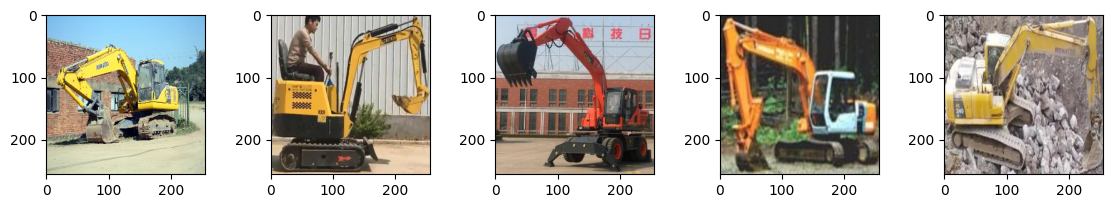

In [9]:
display_class_images('dataset/railway-construction-100/excavator/*.jpg')

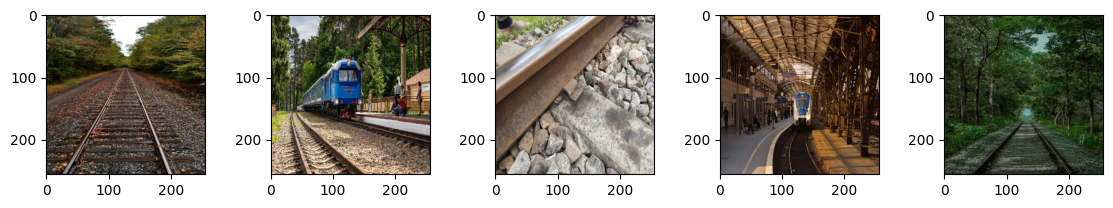

In [10]:
display_class_images('dataset/railway-construction-100/train_tracks/*.jpg')

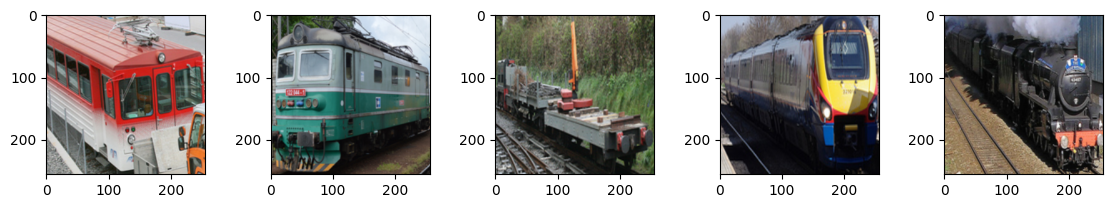

In [11]:
display_class_images('dataset/railway-construction-100/train/*.png')

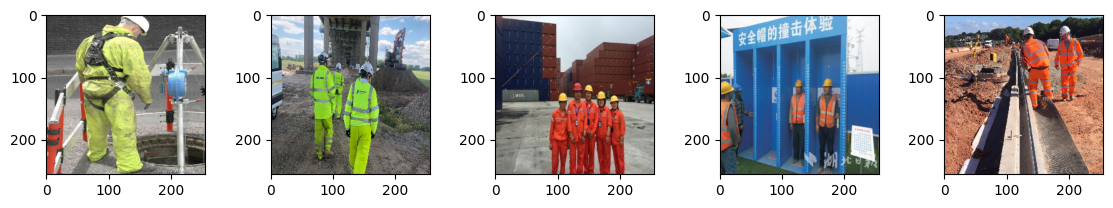

In [12]:
display_class_images('dataset/railway-construction-100/workers/*.jpg')

## **Question 9: Function to split the data and create tensors/dataloaders**

In [13]:
def create_data_loaders(dataset_path, batch_size, train_split, val_split, img_size):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    eval_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    # Load the full dataset (without transforms initially)
    full_dataset = datasets.ImageFolder(dataset_path)

    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)

    # Split indices
    train_end = int(train_split * dataset_size)
    val_end = train_end + int(val_split * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create separate dataset subsets with corresponding transformations
    train_dataset = Subset(datasets.ImageFolder(dataset_path, transform=train_transform), train_indices)
    val_dataset = Subset(datasets.ImageFolder(dataset_path, transform=eval_transform), val_indices)
    test_dataset = Subset(datasets.ImageFolder(dataset_path, transform=eval_transform), test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


## **Question 10: create data loaders (train, val, test) with the create_data_loaders function**

In [14]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    dataset_path, batch_size, train_split, val_split, img_size)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## **Question 11: complete the code (SGD with lr='0.01') and run the training**

In [ ]:
# Initialize model
model = Model(model_name=model_name, num_classes=num_classes, learning_rate=learning_rate)

# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

# Initialize CsvLogger
csv_logger = CSVLogger(LOG_DIR, name=model_name, version='')

# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    logger=[csv_logger],
    callbacks=[checkpoint_callback, early_stop_callback],
)

# Train the model
trainer.fit(model, train_loader, val_loader)

In [67]:
torch.save(model, 'model_sidi.pt')

## **Question 12: visulization function for training curves with plot**

In [45]:
def plot_metrics(log_folder):
  import pandas as pd
  import matplotlib.pyplot as plt

  # Load the CSV file generated by CSVLogger
  df = pd.read_csv(f'{LOG_DIR}/{log_folder}/metrics.csv')
  train_df = df[df['train_loss_epoch'].notna()]
  val_df = df[df['val_loss'].notna()]

  # Plot training loss
  plt.plot(train_df['epoch'], train_df['train_loss_epoch'], label='Train Loss')
  plt.plot(val_df['epoch'], val_df['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot training accuracy
  plt.plot(train_df['epoch'], train_df['train_acc_epoch'], label='Train Acc')
  plt.plot(val_df['epoch'], val_df['val_acc'], label='Val Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

## **Question 13: Display your training curves with the “plot_metrics ” function**

In [ ]:
plot_metrics(model_name)

## **Question 14: check/interpret your model's training curves via plot**

Look at the plot and interpret the results

## **Question 15: Evaluate your first model with test data**

In [ ]:
trainer.test(model,test_loader)

# **Model Benchmarking before compression** #

In [ ]:
!pip install -U pytorch-bench

In [ ]:
from pytorch_bench import benchmark

# Move the example input to the GPU
example_input = torch.randn(1, 3, 224, 224)
example_input.to(example_input.device)

# Benchmark the model
# Move the model to the same device as the input
model.to(example_input.device)
benchmark(model, example_input, gpu_only=True)

## **Question 16: Apply compression (pruning and knowledge distillation)**

In [ ]:
%pip install torch-pruning

In [50]:
#@title ## **Compression Scripts**

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_pruning as tp
import os
import copy
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from functools import partial


assert torch.cuda.is_available(), "CUDA is not available!"

device = torch.device("cuda")

def get_pruner(method, model, example_input, num_classes, global_pruning=True):
    sparsity_learning = False
    if method == "random":
        imp = tp.importance.RandomImportance()
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "l1":
        imp = tp.importance.MagnitudeImportance(p=1)
        pruner_entry = partial(tp.pruner.MagnitudePruner, global_pruning=global_pruning)
    elif method == "group_norm":
        imp = tp.importance.GroupMagnitudeImportance(p=2)
        pruner_entry = partial(tp.pruner.GroupNormPruner, global_pruning=global_pruning)
    else:
        raise NotImplementedError

    unwrapped_parameters = []
    ignored_layers = []
    ch_sparsity_dict = {}
    # ignore output layers
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and m.out_features == num_classes:
            ignored_layers.append(m)
        elif isinstance(m, torch.nn.modules.conv._ConvNd) and m.out_channels == num_classes:
            ignored_layers.append(m)

    pruner = pruner_entry(
        model,
        example_input,
        importance=imp,
        iterative_steps=200,
        pruning_ratio=1.0,
        ignored_layers=ignored_layers,
    )
    return pruner

def progressive_pruning(pruner, model, target_value, example_inputs, mode='compression'):
    model.eval()
    base_ops, base_params = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
    current_value = 1

    while current_value < target_value:
        pruner.step(interactive=False)
        pruned_ops, pruned_params = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)
        current_value = float(base_ops) / pruned_ops if mode == 'speedup' else float(base_params) / pruned_params

    return current_value

def apply_pruning(method, model, compression_ratio, example_input, num_classes, global_pruning):
    pruner = get_pruner(method, model, example_input, num_classes, global_pruning)
    progressive_pruning(pruner, model, compression_ratio, example_input)
    return model

@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader, verbose=True) -> tuple:
    model.eval()
    num_samples = num_correct = loss = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss += F.cross_entropy(outputs, targets, reduction="sum")
        num_samples += targets.size(0)
        num_correct += (outputs.argmax(dim=1) == targets).sum()

    return (num_correct / num_samples * 100).item(), (loss / num_samples).item()


def train_kd(model_student: nn.Module, model_teacher: nn.Module, train_loader: DataLoader,
             test_loader: DataLoader, epochs: int, lr: float, temperature: float, alpha: float,
             weight_decay=5e-4, callbacks=None, save=None, save_only_state_dict=False) -> None:
    optimizer = SGD(model_student.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, epochs)
    criterion = nn.CrossEntropyLoss()
    best_acc = -1
    best_checkpoint = {}

    for epoch in range(epochs):
        model_student.train()
        model_teacher.eval()
        for inputs, targets in tqdm(train_loader, leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            out_student = model_student(inputs)
            out_teacher = model_teacher(inputs)

            predict_student = F.log_softmax(out_student / temperature, dim=1)
            predict_teacher = F.softmax(out_teacher / temperature, dim=1)
            loss = (nn.KLDivLoss(reduction="batchmean")(predict_student, predict_teacher) *
                    (alpha * temperature * temperature) +
                    criterion(out_student, targets) * (1-alpha))

            loss.backward()
            optimizer.step()

            if callbacks:
                for callback in callbacks:
                    callback()

        acc, val_loss = evaluate(model_student, test_loader)
        print(
            f'KD - Epoch {epoch + 1}/{epochs} | Val acc: {acc:.2f} | Val loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if acc > best_acc:
            best_checkpoint['state_dict'] = copy.deepcopy(model_student.state_dict())
            best_acc = acc
        scheduler.step()

    model_student.load_state_dict(best_checkpoint['state_dict'])
    if save:
        torch.save(model_student.state_dict() if save_only_state_dict else model_student, save)
    print(f'Best val acc after KD: {best_acc:.2f}')

# **Define pruning parameters** #

In [ ]:
Compression_ratio = 2 #@param [2,4,8,16] {type:"raw"}
Pruning_method = "group_norm" #@param ["random", "l1", "group_norm"]
Global_pruning = True #@param {type:"boolean"}

example_input = torch.randn(1, 3, 224, 224, device="cuda")
model.cuda()

# **Apply pruning and evaluate pruned model without retraining** #

In [52]:
model = apply_pruning(Pruning_method, model, Compression_ratio, example_input, num_classes, Global_pruning)

In [ ]:
trainer.test(model,test_loader)

# **Define knowledge distillation parameters** #

In [58]:
model_teacher = Model.load_from_checkpoint("checkpoints/best-checkpoint.ckpt").to("cuda")
Learning_rate = 0.01 #@param [0.01, 0.001] {type:"raw"}
Temperature = 4 #@param [1, 3, 4, 10] {type:"raw"}
Alpha = 0.3 #@param [0, 0.3, 0.5, 0.9, 1] {type:"raw"}
Epochs_kd = 30 #@param [1, 5, 10, 20, 30] {type:"raw"}

# **Retrain the model using Knowledge Distillation** #

In [ ]:
# Retrain model using kd
train_kd(model.to('cuda'), model_teacher, train_loader, val_loader, Epochs_kd, Learning_rate, Temperature, Alpha)

In [ ]:
# Evalute opimized model
trainer.test(model, dataloaders=test_loader)

# **Model Benchmarking after compression** #

In [ ]:
from pytorch_bench import benchmark

# Move the example input to the GPU
example_input = torch.randn(1, 3, 224, 224)
example_input.to(example_input.device)

# Benchmark the model
# Move the model to the same device as the input
model.to(example_input.device)
benchmark(model, example_input, gpu_only=True)